In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mit-adobe-5k-dataset/validation/INPUT_IMAGES/a1638-IMG_3497_P1.5.JPG
/kaggle/input/mit-adobe-5k-dataset/validation/INPUT_IMAGES/a4708-Duggan_090323_6142_P1.5.JPG
/kaggle/input/mit-adobe-5k-dataset/validation/INPUT_IMAGES/a4005-IMG_0044_N1.JPG
/kaggle/input/mit-adobe-5k-dataset/validation/INPUT_IMAGES/a1390-_DGW6414_N1.JPG
/kaggle/input/mit-adobe-5k-dataset/validation/INPUT_IMAGES/a1820-tc_DSC2003_N1.5.JPG
/kaggle/input/mit-adobe-5k-dataset/validation/INPUT_IMAGES/a2371-LS_D4O0320_P1.JPG
/kaggle/input/mit-adobe-5k-dataset/validation/INPUT_IMAGES/a3989-WP_CRW_8495_N1.JPG
/kaggle/input/mit-adobe-5k-dataset/validation/INPUT_IMAGES/a4975-20090414_at_22h52m18__MG_1358_P1.JPG
/kaggle/input/mit-adobe-5k-dataset/validation/INPUT_IMAGES/a3159-LS051025_day_2_LL002_N1.5.JPG
/kaggle/input/mit-adobe-5k-dataset/validation/INPUT_IMAGES/a3717-IMG_1549_P1.5.JPG
/kaggle/input/mit-adobe-5k-dataset/validation/INPUT_IMAGES/a1921-IMG_0766_P1.5.JPG
/kaggle/input/mit-adobe-5k-dataset/validation/I

In [3]:
pip install tensorflow opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


## Import Library
Mengimport semua library yang dibutuhkan untuk membangun model

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm

2025-05-29 13:25:51.247266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748525151.470000      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748525151.531088      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Persiapan Data dan Parameter Pelatihan
Mendefinisikan path utama (dataset MIT Adobe 5k), image_size, batch_size dan epoch. Kemudian mencocokan gambar input dan ground truth yang ada di dataset utama. 

In [3]:
# Define constants
BASE_PATH = "/kaggle/input/mit-adobe-5k-dataset"
IMG_SIZE = (192, 192) # Width, Height
BATCH_SIZE = 4
EPOCHS = 10

def get_prefix_id(filename):
    # Ambil bagian sebelum tanda '-' pertama, misal 'a0001' dari 'a0001-jmac_DSC1459_0.JPG'
    base = os.path.basename(filename)
    prefix = base.split('-')[0]
    return prefix.lower()

def get_image_paths(input_folder, gt_folder=None):
    
    input_files = sorted(os.listdir(input_folder))
    
    input_paths = []
    gt_paths = [] if gt_folder else None

    if gt_folder:
        gt_files = sorted(os.listdir(gt_folder))
        # Create a dictionary mapping GT prefix to its full filename
        gt_dict = {get_prefix_id(f): f for f in gt_files}

    for filename in tqdm(input_files, desc=f"Collecting paths from {input_folder}"):
        input_path = os.path.join(input_folder, filename)
        
        if gt_folder:
            prefix = get_prefix_id(filename)
            if prefix in gt_dict:
                gt_path = os.path.join(gt_folder, gt_dict[prefix])
                input_paths.append(input_path)
                gt_paths.append(gt_path)
            else:
                print(f"⚠️ No matching GT for: {filename}")
        else:
            input_paths.append(input_path)
            
    return (input_paths, gt_paths) if gt_folder else input_paths


## Pre-processing data
Pada bagian ini kami mempersiapkan gambar sebelum digunakan dalam pelatihan model. Gambar dibaca dari path nya, kemudian di-decode menjadi format RGB, resize ke ukuran yang sudah ditentukan (192x192) dan menormalisasikan gambar ke rentang pixel [0, 1]. Proses ini memastikan bahwa semua gambar memiliki ukuran dan format yang konsisten untuk dimasukkan ke dalam model.

In [4]:
def preprocess_image(image_path): 

    # Read the image file
    img = tf.io.read_file(image_path)
    # Decode it as an image, explicitly setting channels to 3 (RGB)
    # This helps tf.image.decode_image infer the shape correctly.
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    
    # Ensure the image has a static shape for resizing.
    img.set_shape([None, None, 3]) 
    
    # Resize the image
    img = tf.image.resize(img, IMG_SIZE)
    
    # Convert to float32 and normalize to [0, 1]
    img = tf.cast(img, tf.float32) / 255.0
    return img


## Membuat Dataset TensorFlow
Pada bagian ini, kami membangun pipeline `tf.data.Dataset` untuk menangani data input dan ground truth secara efisien. Dataset dibuat dari daftar path gambar, lalu masing-masing gambar diproses melalui fungsi pre-processing. Dataset kemudian di-shuffle (acak), di-batch, dan di-prefetch agar proses pelatihan berjalan lebih cepat dan efisien dengan memanfaatkan paralelisme dan pipeline asinkron di TensorFlow.

In [5]:
def create_dataset(input_paths, gt_paths=None, shuffle=True):
    
    #Creates a TensorFlow tf.data.Dataset pipeline.
    if gt_paths:
        # Create a dataset from input and ground truth paths
        dataset = tf.data.Dataset.from_tensor_slices((input_paths, gt_paths))
        
        # Map the preprocessing function to both input and GT images
        dataset = dataset.map(
            lambda x, y: (preprocess_image(x), preprocess_image(y)),
            num_parallel_calls=tf.data.AUTOTUNE # Optimize parallel processing
        )
    else:
        # Create a dataset from input paths only
        dataset = tf.data.Dataset.from_tensor_slices(input_paths)
        
        # Map the preprocessing function to input images
        dataset = dataset.map(
            lambda x: preprocess_image(x),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    if shuffle:
        # Shuffle the dataset
        dataset = dataset.shuffle(buffer_size=len(input_paths)) # Shuffle buffer size should be large enough

    # Batch the dataset
    dataset = dataset.batch(BATCH_SIZE)
    # Prefetch data to overlap data preprocessing and model execution
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset


## Load Path Gambar dan Membuat Objek Dataset TensorFlow
Pada tahap ini, dilakukan dua proses utama:

1. Dilakukan proses pemuatan path gambar dari dataset MIT-Adobe FiveK untuk tiga tujuan utama:
   * Training: Memuat pasangan gambar input dan ground truth dari direktori training/.
   * Validation: Memuat data dari direktori validation/ untuk mengevaluasi performa model selama pelatihan.
   * Testing: Memuat data dari direktori testing/ menggunakan hasil edit dari salah satu expert (expert_a_testing_set) sebagai ground truth.
Setiap gambar input akan dicocokkan dengan ground truth-nya berdasarkan prefix ID.

2. Setelah path gambar berhasil dimuat, langkah selanjutnya adalah membentuk pipeline tf.data.Dataset untuk masing-masing:
   * train_dataset: Digunakan untuk melatih model. Disusun dari pasangan input dan GT, kemudian di-shuffle, dibatch, dan diprefetch untuk efisiensi.
   * val_dataset: Dataset validasi yang tidak perlu di-shuffle karena digunakan hanya untuk evaluasi.
   * test_dataset: Dataset pengujian akhir, juga tidak perlu di-shuffle.

In [6]:
# --- Load image paths for training, validation, and testing ---
print("Loading training image paths...")
train_input_paths, train_gt_paths = get_image_paths(
    os.path.join(BASE_PATH, "training/INPUT_IMAGES"),
    os.path.join(BASE_PATH, "training/GT_IMAGES")
)

print("Loading validation image paths...")
val_input_paths, val_gt_paths = get_image_paths(
    os.path.join(BASE_PATH, "validation/INPUT_IMAGES"),
    os.path.join(BASE_PATH, "validation/GT_IMAGES")
)

print("Loading testing image paths...")
test_input_paths, test_gt_paths = get_image_paths(
    os.path.join(BASE_PATH, "testing/INPUT_IMAGES"),
    os.path.join(BASE_PATH, "testing/expert_a_testing_set")
)

Loading training image paths...


Loading validation image paths...


Loading testing image paths...


In [7]:
print("\nCreating TensorFlow Datasets...")
train_dataset = create_dataset(train_input_paths, train_gt_paths, shuffle=True)
val_dataset = create_dataset(val_input_paths, val_gt_paths, shuffle=False) # No need to shuffle validation
test_dataset = create_dataset(test_input_paths, test_gt_paths, shuffle=False) # No need to shuffle testing

print("\nDataset creation complete. You can now use these datasets for model training.")
print(f"Train Dataset: {train_dataset}")
print(f"Validation Dataset: {val_dataset}")
print(f"Test Dataset: {test_dataset}")



Creating TensorFlow Datasets...

Dataset creation complete. You can now use these datasets for model training.
Train Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None))>
Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None))>
Test Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None))>


I0000 00:00:1748525186.758817      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748525186.759478      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## Membangun model EDSR (Enhanced Deep Super-Resolution Network
Model EDSR (Enhanced Deep Super-Resolution) yang dibangun digunakan untuk meningkatkan kualitas gambar. Model terdiri dari layer konvolusi awal untuk ekstraksi fitur, beberapa blok residual tanpa batch normalization untuk menjaga informasi penting, dan koneksi skip global yang menghubungkan fitur awal ke akhir agar informasi tidak hilang. Di akhir, layer konvolusi digunakan untuk menghasilkan gambar RGB dengan aktivasi sigmoid. Model menerima input gambar berukuran 192x192 piksel dengan 3 channel (RGB).

In [8]:
# --- 1. Build the Model (EDSR-like Architecture) ---

def residual_block(x, filters):
    res = x
    x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(filters, 3, padding='same')(x) # No activation here
    x = layers.Add()([res, x]) # Residual connection
    return x

def build_edsr_model(input_shape, num_res_blocks=6, filters=24):
    """
    Builds an EDSR-like model for image enhancement.
    
    Args:
        input_shape (tuple): Shape of the input images (height, width, channels).
        num_res_blocks (int): Number of residual blocks in the model.
        filters (int): Number of filters in the convolutional layers.
    """
    inputs = keras.Input(shape=input_shape)

    # Initial feature extraction
    x = layers.Conv2D(filters, 3, padding='same')(inputs)
    
    # Store initial features for global skip connection
    res_input = x

    # Residual blocks
    for _ in range(num_res_blocks):
        x = residual_block(x, filters)

    # Global skip connection
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.Add()([res_input, x]) # Add global skip

    # Final convolution layer to map to 3 channels (RGB)
    outputs = layers.Conv2D(3, 1, activation='sigmoid', padding='same')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model
    
input_shape = (*IMG_SIZE, 3) # (height, width, channels)
model = build_edsr_model(input_shape)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 192, 192, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 192, 192, 24)   │            672 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 192, 192, 24)   │          5,208 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 192, 192, 24)   │          5,208 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 192, 192, 24)   │              0 │ conv2d[0][0],          │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 192, 192, 24)   │          5,208 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 192, 192, 24)   │          5,208 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 192, 192, 24)   │              0 │ add[0][0],             │
│                           │                        │                │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 192, 192, 24)   │          5,208 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 192, 192, 24)   │          5,208 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 192, 192, 24)   │              0 │ add_1[0][0],           │
│                           │                        │                │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 192, 192, 24)   │          5,208 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 192, 192, 24)   │          5,208 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 192, 192, 24)   │              0 │ add_2[0][0],           │
│                           │                        │                │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 192, 192, 24)   │          5,208 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 192, 192, 24)   │          5,208 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 192, 192, 24)   │              0 │ add_3[0][0],           │
│                           │                        │                │ conv2d_10[0][0]        │
├──────────────────────

 Total params: 68,451 (267.39 KB)

 Trainable params: 68,451 (267.39 KB)

 Non-trainable params: 0 (0.00 B)

## Train model
Setelah model EDSR dibangun, langkah berikutnya adalah mengompilasi model dengan optimizer Adam dan fungsi loss MSE. Proses pelatihan dilakukan dengan menggunakan dataset pelatihan dan validasi selama beberapa epoch. Untuk meningkatkan performa, digunakan callback ModelCheckpoint agar menyimpan model terbaik berdasarkan validasi loss, serta EarlyStopping untuk menghentikan pelatihan saat validasi loss tidak membaik dalam beberapa epoch. Setelah pelatihan selesai, model terbaik yang tersimpan akan dimuat untuk digunakan.

In [9]:
# --- 2. Compile and Train the Model ---
print("\nCompiling the model...")
model.compile(optimizer='adam', loss='mse')

# Define callbacks
# ModelCheckpoint: Save the best model based on validation loss
checkpoint_filepath = 'best_image_enhancement_model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False, # Save the entire model
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# EarlyStopping: Stop training if validation loss doesn't improve for a few epochs
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5, # Number of epochs with no improvement after which training will be stopped.
    mode='min',
    verbose=1,
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
)

print(f"\nStarting training for {EPOCHS} epochs...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[model_checkpoint_callback, early_stopping_callback],
    verbose=1
)

print("\nTraining complete.")

# Load the best model if it was saved
try:
    best_model = keras.models.load_model(checkpoint_filepath)
    print(f"Loaded best model from {checkpoint_filepath}")
except Exception as e:
    print(f"Could not load best model: {e}. Using the last trained model.")
    best_model = model # Fallback to the last trained model if loading fails



Compiling the model...

Starting training for 10 epochs...
Epoch 1/10


I0000 00:00:1748525282.158656     100 service.cc:148] XLA service 0x7b367c05d850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748525282.159321     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748525282.159342     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748525282.765629     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


   5/4419 ━━━━━━━━━━━━━━━━━━━━ 2:39 36ms/step - loss: 0.1194  

I0000 00:00:1748525285.683820     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4419/4419 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0312
Epoch 1: val_loss improved from inf to 0.02541, saving model to best_image_enhancement_model.keras
4419/4419 ━━━━━━━━━━━━━━━━━━━━ 259s 39ms/step - loss: 0.0312 - val_loss: 0.0254
Epoch 2/10
4418/4419 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0247
Epoch 2: val_loss improved from 0.02541 to 0.02419, saving model to best_image_enhancement_model.keras
4419/4419 ━━━━━━━━━━━━━━━━━━━━ 227s 38ms/step - loss: 0.0247 - val_loss: 0.0242
Epoch 3/10
4418/4419 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0237
Epoch 3: val_loss did not improve from 0.02419
4419/4419 ━━━━━━━━━━━━━━━━━━━━ 227s 38ms/step - loss: 0.0237 - val_loss: 0.0243
Epoch 4/10
4418/4419 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0230
Epoch 4: val_loss improved from 0.02419 to 0.02304, saving model to best_image_enhancement_model.keras
4419/4419 ━━━━━━━━━━━━━━━━━━━━ 226s 38ms/step - loss: 0.0230 - val_loss: 0.0230
Epoch 5/10
4418/4419 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - lo

## Visualisasi Proses Pelatihan Model
Visualisasi grafik loss selama proses pelatihan digunakan untuk memantau performa model. Grafik ini menampilkan nilai loss pada data training dan validasi di setiap epoch.

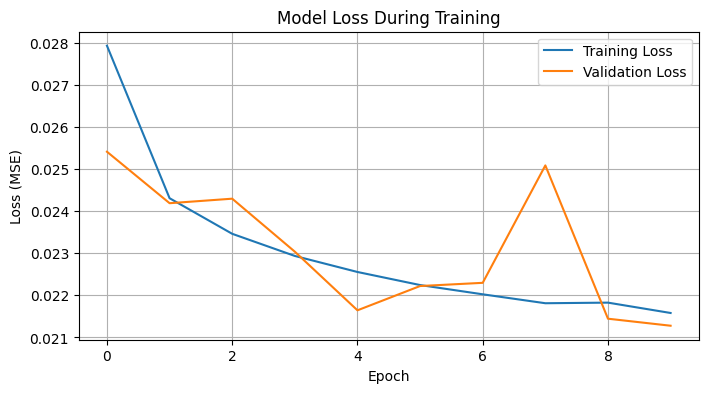

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## Evaluasi model
Model yang telah dilatih dievaluasi menggunakan dataset pengujian untuk mengukur performanya. Evaluasi ini menghasilkan nilai loss (MSE) yang menunjukkan seberapa baik model dalam meningkatkan kualitas gambar pada data yang belum pernah dilihat sebelumnya.

In [10]:
# --- 3. Evaluate the Model on the Test Set ---
print("\nEvaluating the model on the test dataset...")
test_loss = best_model.evaluate(test_dataset)
print(f"Test Loss (MSE): {test_loss:.4f}")


Evaluating the model on the test dataset...
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - loss: 0.0287
Test Loss (MSE): 0.0261


## Visualisasi Hasil Enhancement
Visualisasi hasil model dilakukan dengan mengambil sejumlah gambar dari dataset pengujian. Gambar input asli, gambar ground truth (hasil yang diharapkan), dan gambar yang dihasilkan oleh model (enhanced) ditampilkan secara berdampingan untuk memudahkan perbandingan dan penilaian kualitas peningkatan citra oleh model.


Generating visualizations...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


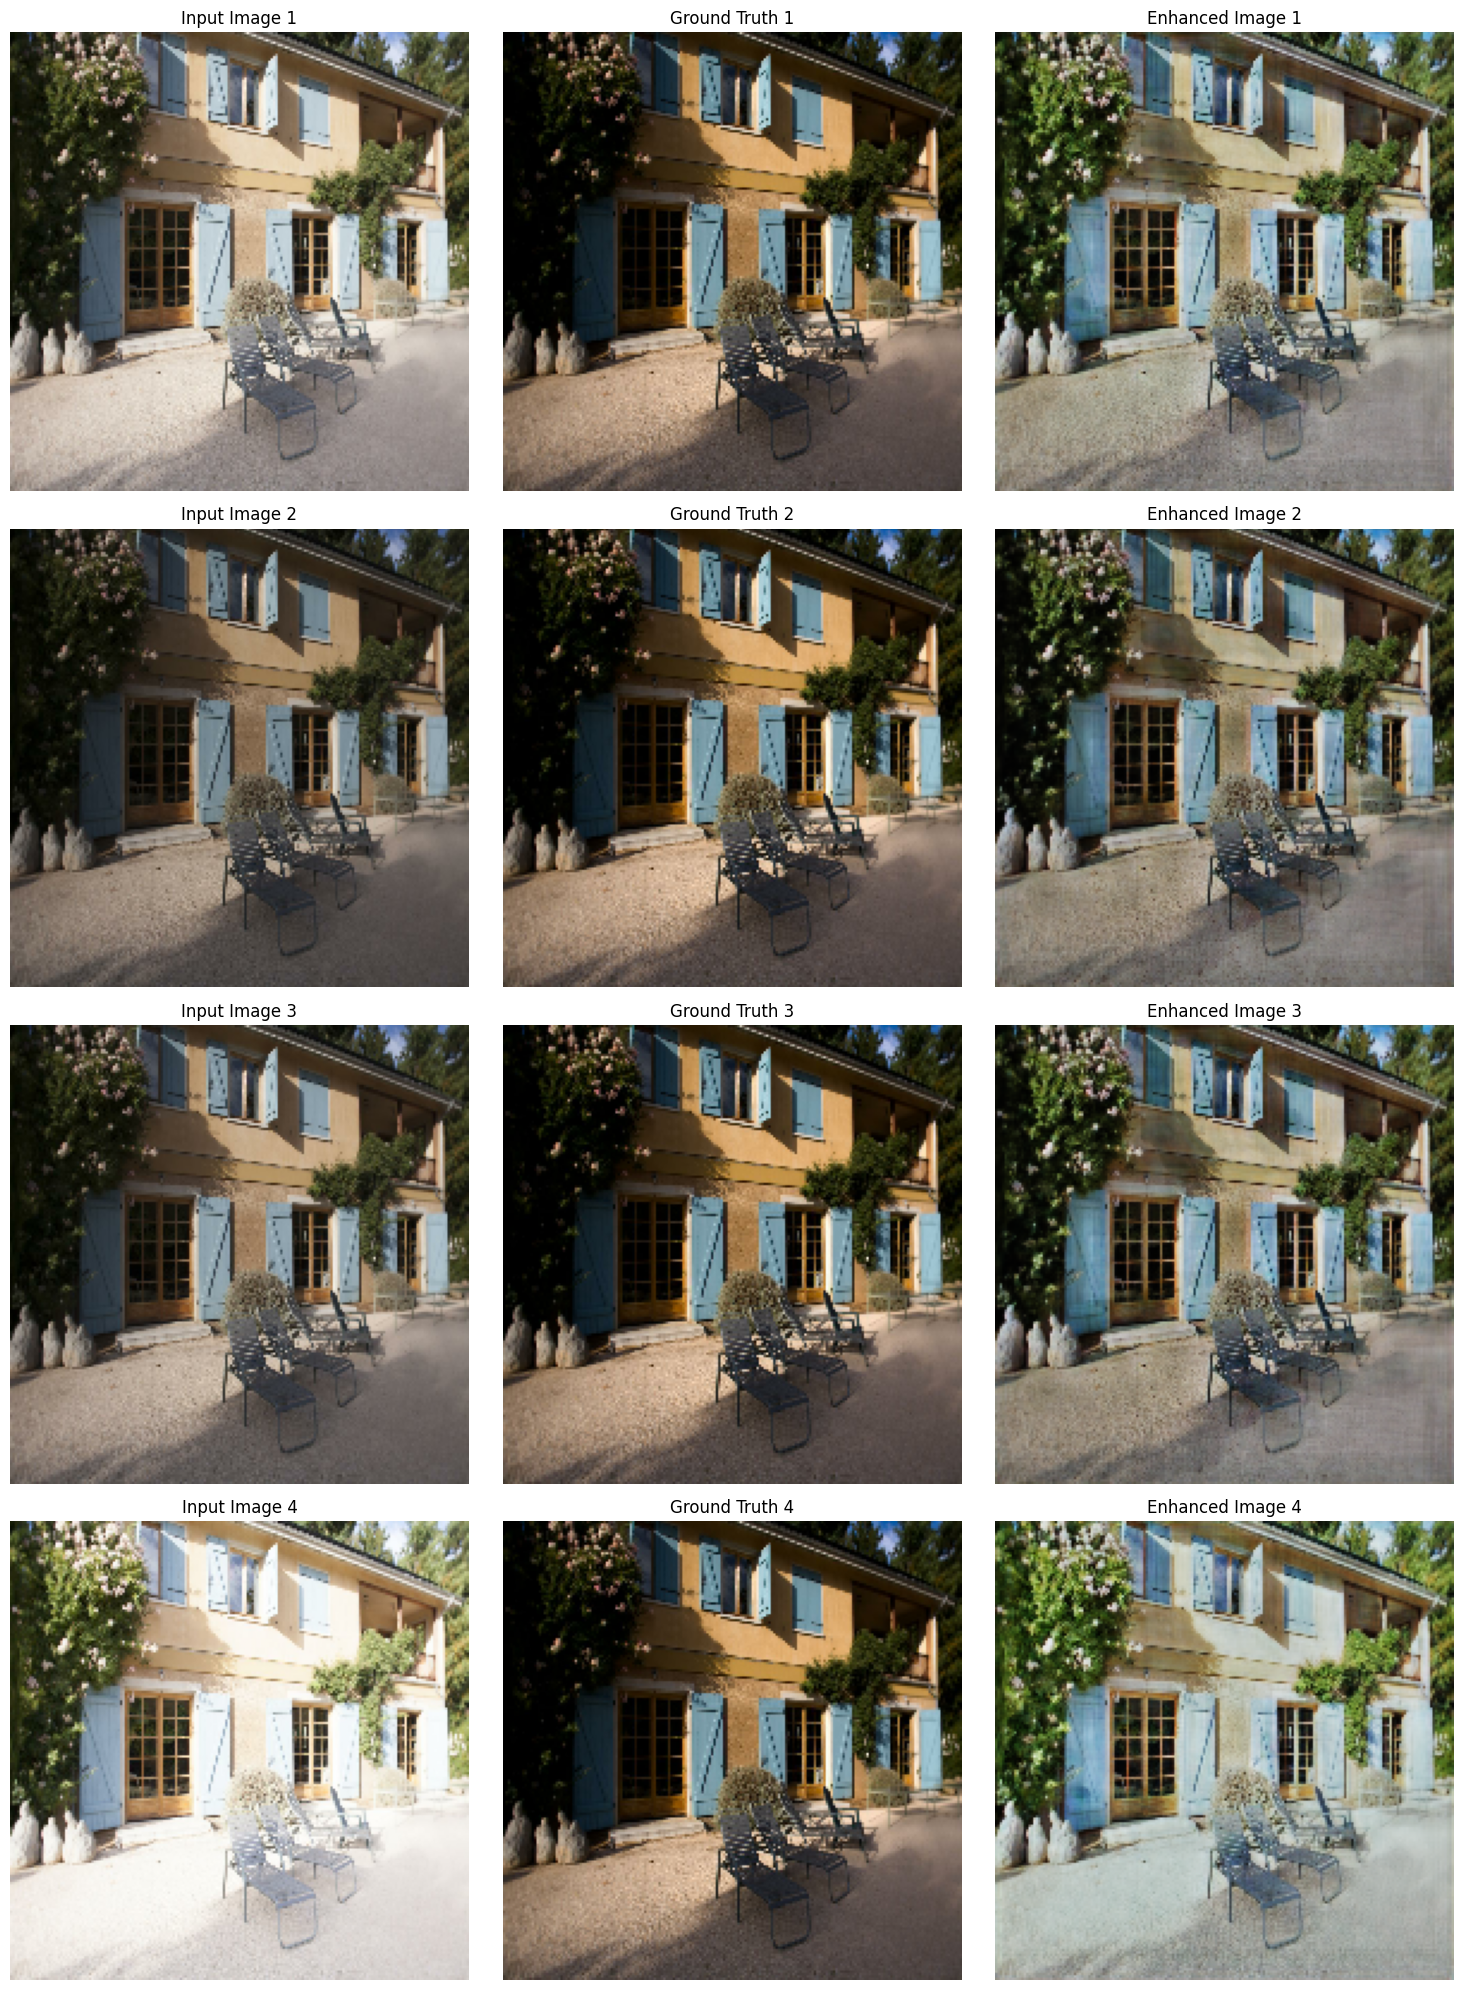

In [13]:
# --- 4. Visualize Results ---
print("\nGenerating visualizations...")

# Get a batch of images from the test dataset for visualization
sample_test_batch = next(iter(test_dataset.take(1))) # Take one batch

input_images_sample = sample_test_batch[0].numpy()
gt_images_sample = sample_test_batch[1].numpy()

# Set num_display_images to be the actual batch size or smaller
# This ensures we don't try to display more images than available in the batch.
num_display_images = min(5, input_images_sample.shape[0]) 


# Predict enhanced images
enhanced_images_sample = best_model.predict(input_images_sample)

plt.figure(figsize=(15, num_display_images * 5))

for i in range(num_display_images):
    # Original Input Image
    plt.subplot(num_display_images, 3, i * 3 + 1)
    plt.imshow(input_images_sample[i])
    plt.title(f"Input Image {i+1}")
    plt.axis('off')

    # Ground Truth Image
    plt.subplot(num_display_images, 3, i * 3 + 2)
    plt.imshow(gt_images_sample[i])
    plt.title(f"Ground Truth {i+1}")
    plt.axis('off')

    # Enhanced Image
    plt.subplot(num_display_images, 3, i * 3 + 3)
    plt.imshow(enhanced_images_sample[i])
    plt.title(f"Enhanced Image {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()